# Temporal filtering
Explore some temporal filtering of OM4 DSL (`zos`) variability.

In [1]:
import numpy as np
import xarray as xr
import momlevel
import xwavelet as xw
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
data_dir = '/work/jet/sea_level_covariability/data/zarr/'
fname = 'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3_global_1958to2017_zos_monthly'
ds = xr.open_zarr(f'{data_dir+fname}',use_cftime=True)

Remove the seasonal cycle and linear trend

In [3]:
da = ds.zos-ds.zos.mean('time')
da_anm = da.groupby('time.month') - da.groupby('time.month').mean('time')
da_dtr = momlevel.trend.linear_detrend(da_anm)

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 60 times more chunks
  return self.array[key]


For now, subselect the Equatorial Pacific and load into memory for quick plotting.

In [5]:
# select NINO3 region
#zos = ds.zos.sel(yh=slice(-5, 5),xh=slice(-200, -100)).chunk({'time': -1})
#
with ProgressBar():
    zos = da_dtr.sel(yh=slice(-5, 5),xh=slice(-200, -100)).chunk({'time': -1}).load()

[########################################] | 100% Completed | 430.68 s


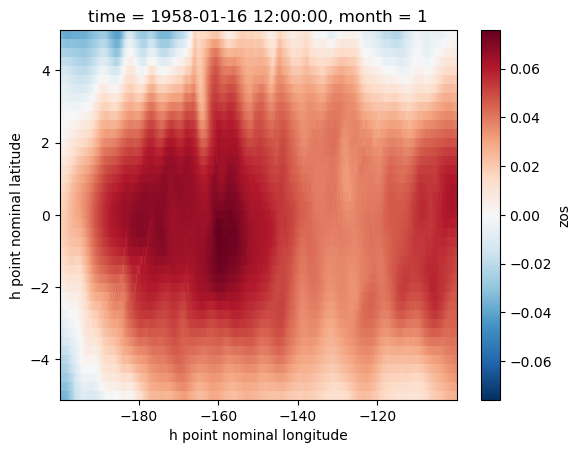

In [6]:
zos[0].plot()

## Butterworth filter using `scipy.signal`
Here we try a well-know Low-Pass, High-Pass, and Band-Pass Filtering Approaches using the Butterworth filter

In [7]:
from scipy.signal import butter, filtfilt

In [8]:
# Choose the time scale for the cutoff (in years)
years = 3
order = 4  # order of the filter

In [9]:
# Determine the sampling frequency (assuming regular intervals, e.g., monthly data)
# Convert years to hours (assuming time is in hours since the reference date)
years_to_hours = years * 365.25 * 24
sampling_interval = np.mean(np.array([float(dt) for dt in ds.dt.values])/60/60) # in hours
sampling_rate = 1 / sampling_interval

# Design a Butterworth low-pass filter
cutoff_frequency = 1 / years_to_hours  # cutoff frequency in cycles per hour
b, a = butter(order, cutoff_frequency, btype='low', fs=sampling_rate)

# Apply the filter to the time series data
zos_filt_low = xr.DataArray(filtfilt(b, a, zos.sel({'xh':-150,'yh':1},method='nearest').values), 
                        dims=['time'], coords={'time': ds.time})

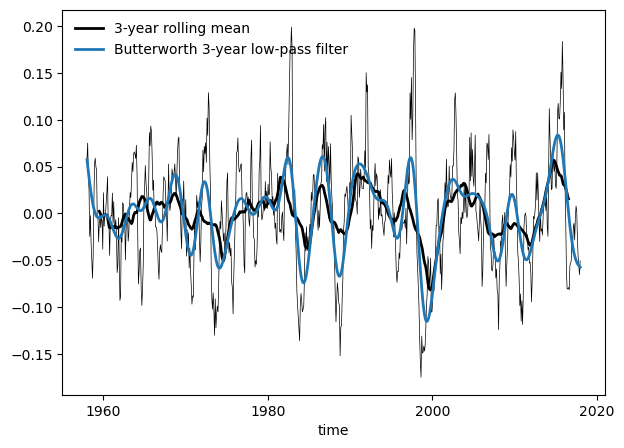

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
zos.sel({'xh':-150,'yh':1},method='nearest').plot(ax=ax,c='k',lw=0.5)
zos.rolling(time=years*12,center=True).mean().sel({'xh':-150,'yh':1},method='nearest')\
            .plot(ax=ax,c='k',lw=2, label='%s-year rolling mean'%str(years))
zos_filt_low.plot(ax=ax,lw=2,label='Butterworth %s-year low-pass filter'%str(years))
ax.legend(frameon=False, fancybox=False, loc='upper left', ncol=1, fontsize=10)
plt.show()

In [11]:
# Design a Butterworth high-pass filter
b, a = butter(order, cutoff_frequency, btype='high', fs=sampling_rate)

# Apply the filter to the time series data
zos_filt_high = xr.DataArray(filtfilt(b, a, zos.sel({'xh':-150,'yh':1},method='nearest').values), 
                             dims=['time'], coords={'time': ds['time']})

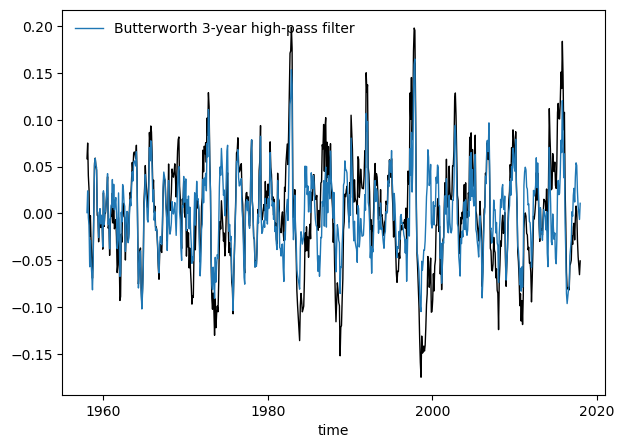

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
#(zos-zos.mean('time')).sel({'xh':-150,'yh':1},method='nearest').plot(ax=ax,c='k',lw=1)
zos.sel({'xh':-150,'yh':1},method='nearest').plot(ax=ax,c='k',lw=1)
zos_filt_high.plot(ax=ax,lw=1,label='Butterworth %s-year high-pass filter'%str(years))
ax.legend(frameon=False, fancybox=False, loc='upper left', ncol=1, fontsize=10)
plt.show()

In [13]:
# Try band-pass filter to isolate variability between 2 and 5 years 
years_high = 2
years_low = 5

# Design a Butterworth band-pass filter
low_cutoff_frequency = 1 / (years_low * 365.25 * 24)  # low cutoff frequency in cycles per hour
high_cutoff_frequency = 1 / (years_high * 365.25 * 24) # high cutoff frequency in cycles per hour
b, a = butter(order, [low_cutoff_frequency, high_cutoff_frequency], btype='band', fs=sampling_rate)

# Apply the filter to the time series data
zos_filt_band = xr.DataArray(filtfilt(b, a, zos.sel({'xh':-150,'yh':1},method='nearest').values), 
                             dims=['time'], coords={'time': ds['time']})

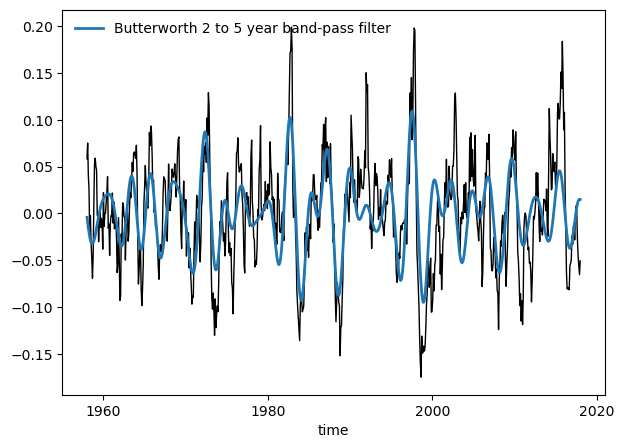

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
zos.sel({'xh':-150,'yh':1},method='nearest').plot(ax=ax,c='k',lw=1)
zos_filt_band.plot(ax=ax,lw=2,label='Butterworth %s to %s year band-pass filter'%(str(years_high),str(years_low)))
ax.legend(frameon=False, fancybox=False, loc='upper left', ncol=1, fontsize=10)
plt.show()

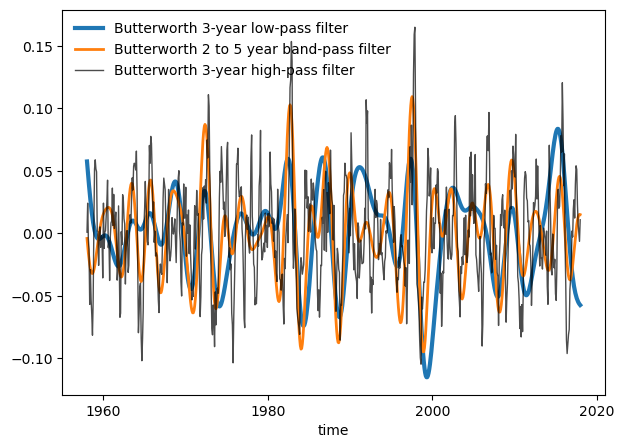

In [23]:
fig, ax = plt.subplots(figsize=(7,5))
zos_filt_low.plot(ax=ax,lw=3, label='Butterworth %s-year low-pass filter'%str(years))
zos_filt_band.plot(ax=ax,lw=2,label='Butterworth %s to %s year band-pass filter'%(str(years_high),str(years_low)))
zos_filt_high.plot(ax=ax,lw=1,c='k',alpha=0.7,label='Butterworth %s-year high-pass filter'%str(years))
ax.legend(frameon=False, fancybox=False, loc='upper left', ncol=1, fontsize=10)
plt.show()

## Use xarray friendly `xwavelet` package

The `xw.frequency_filter` function provides an xarray front end to Scipy-based frequency filter. A N-th order Butterworth filter, known for its flat frequency response in the pass-band, is used in this function and the filter order is adjustable at runtime.
Input:
- Input data array: `da_dtr`
- Time frequency to use as a cutoff. Two values are required to use bandpass functionality.
- `btype`: The type of filter: "lowpass", "highpass", "bandpass"

For example: 
- A highpass filter with a 10-year cutoff will filter out any variability that is longer than 10 years.
- A lowpass filter with a 10-year cutoff will filter out any variablity that is longer than 10 years.

In [12]:
zos_hp3y = xw.frequency_filter(zos, '3Y',  btype='highpass', iirf_format='sos')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xwavelet/filtering.py:139: UserWarning: Irregular sampling frequency detected - using an average value.
  warnings.warn("Irregular sampling frequency detected - using an average value.")


In [13]:
zos_hp3y[0].plot()

ValueError: Sampling frequency fs must be a single scalar.

In [43]:
with ProgressBar():
    zos_hp3y_loc = zos_hp3y.sel({'xh':-150,'yh':1},method='nearest').load()

[####################################### ] | 99% Completed | 623.44 ms


ValueError: Sampling frequency fs must be a single scalar.

In [40]:
zos_lp3y = xw.frequency_filter(zos, '3Y', btype='lowpass')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xwavelet/filtering.py:139: UserWarning: Irregular sampling frequency detected - using an average value.
  warnings.warn("Irregular sampling frequency detected - using an average value.")


In [41]:
with ProgressBar():
    zos_lp3y_loc = zos_lp3y.sel({'xh':-150,'yh':1},method='nearest').load()

[####################################### ] | 99% Completed | 1.83 s ms


ValueError: Sampling frequency fs must be a single scalar.

In [34]:
xw.frequency_filter?

Signature:
xw.frequency_filter(
    arr,
    cutoff,
    dim='time',
    btype='lowpass',
    filter_order=5,
    iirf_format='ba',
    suppress_warnings=False,
)
Docstring:
Function to filter an xarray time series

This function provides an xarray front end to Scipy-based frequency
filter. A N-th order Butterworth filter, known for its flat frequency
response in the pass-band, is used in this function and the filter order
is adjustable at runtime.

The cutoff frequency is given in the same calendar units as NumPy's
timedelta class. Some examples are "6M" = 6 months, "1Y" = 1 year,
"10Y" = 10 years. The function leverages xarray's conversion to
np.datetime objects for the time coordinate to make this function
agnostic of the input array's time frequency. See this url for
more details: https://numpy.org/doc/stable/reference/arrays.datetime.html

The type of filtering can be either "highpass", "lowpass", or "bandpass"

Parameters
----------
arr : xarray.core.dataarray.DataArray
    Input

In [45]:
zos_ftd = xw.frequency_filter(zos, ['3Y','10Y'], btype= 'bandpass')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xwavelet/filtering.py:139: UserWarning: Irregular sampling frequency detected - using an average value.
  warnings.warn("Irregular sampling frequency detected - using an average value.")


In [46]:
with ProgressBar():
    zos_ftd_loc = zos_ftd.sel({'xh':-150,'yh':1},method='nearest').load()

[####################################### ] | 99% Completed | 1.71 s ms


ValueError: Sampling frequency fs must be a single scalar.